## Spam Detection Algorithm Comparison

**Authors:** Alexander Alfaro **Mail:** almi21@student.bth.se


**Objective:** The aim of this assignment is to experimentally compare the computational and predictive performance of three learning algorithms on a spam detection task using the Spambase dataset.

**Algorithms Used:**
1. Random Forest
2. Logistic Regression
3. K-Nearest Neighbors (KNN)

**Evaluation Measures:**
- Computational performance in terms of training time
- Predictive performance based on accuracy
- Predictive performance based on F-measure

**Procedure:**
- Run stratified ten-fold cross-validation tests.
- Present results as in Example 12.4 of the literature.
- Conduct the Friedman test and report results as in Example 12.8.
- Use the Nemenyi test to determine significant differences if applicable.

In [49]:
# Import Libraries
# Import the necessary Python libraries for data manipulation, model training, and evaluation.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import time
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import log_loss
import math
from tabulate import tabulate
import warnings

# Set random seed for reproducibility
np.random.seed(42)
# Set the Seaborn style
sns.set_theme(style="whitegrid")
# Ignore warnings
warnings.filterwarnings("ignore")

## 1. Load the Spambase Dataset

The dataset is loaded from the UCI Machine Learning Repository. It contains features extracted from email messages, with the goal of classifying them as spam or non-spam. The dataset is used to evaluate the performance of different machine learning algorithms in detecting spam.

In [50]:
# Load the Spambase Dataset
def load_data():
    """
    Load the Spambase dataset from UCI ML repository
    Returns:
        X: features
        y: labels
    """
    # Load the dataset
    data = pd.read_csv("spambase.data", header=None)
    data = data.values

    X = data[:, :-1]
    y = data[:, -1]

    print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features")
    print(f"Class distribution: {np.sum(y == 1)} spam emails ({np.sum(y == 1) / len(y) * 100:.1f}%) and {np.sum(y == 0)} non-spam emails ({np.sum(y == 0) / len(y) * 100:.1f}%)")

    return X, y

# Load data
X, y = load_data()

Dataset loaded: 4601 samples with 57 features
Class distribution: 1813 spam emails (39.4%) and 2788 non-spam emails (60.6%)


## 2. Initialize Classifiers

We will use three classifiers for this comparison:
1. **Random Forest**: An ensemble method that uses multiple decision trees to improve predictive accuracy and control overfitting.
2. **Support Vector Machine (SVM)**: A powerful classifier that works well in high-dimensional spaces and is effective in cases where the number of dimensions exceeds the number of samples.
3. **K-Nearest Neighbors (KNN)**: A simple, instance-based learning algorithm that classifies samples based on the majority class of their nearest neighbors.

In [51]:
# Initialize Classifiers
def initialize_classifiers():
    """
    Initialize the three chosen classifiers
    Returns:
        list of (name, classifier) tuples
    """
    classifiers = [
        ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
        ("Logistic Regression", LogisticRegression(solver='liblinear', C=0.1, max_iter=2000, random_state=42)),
        ("KNN", KNeighborsClassifier(n_neighbors=5))
    ]
    return classifiers

# Initialize classifiers
classifiers = initialize_classifiers()

## 3. Perform Cross-Validation

Stratified 10-fold cross-validation is used to evaluate each classifier on the dataset. This method ensures that each fold has the same proportion of class labels as the entire dataset, providing a more reliable estimate of the model's performance. We measure three metrics:
- **Accuracy**: The proportion of correctly classified instances.
- **F1 Score**: The harmonic mean of precision and recall, useful for imbalanced datasets.
- **Training Time**: The time taken to train the model, indicating computational efficiency.

In [52]:
# Perform Cross-Validation
def perform_cross_validation(X, y, classifier, metric):
    """
    Perform stratified 10-fold cross-validation
    Args:
        X: features
        y: labels
        classifier: the classifier to evaluate
        metric: evaluation metric (accuracy, f1, or time)
    Returns:
        list of scores for each fold
    """
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = classifier.predict(X_test)
        
        if metric == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'f1':
            score = f1_score(y_test, y_pred)
        else:  # training time
            score = train_time
            
        scores.append(score)
    
    return scores

## 4. Statistical Tests

To determine if there are statistically significant differences between the classifiers, we perform the following tests:

- **Friedman Test**: A non-parametric test used to detect differences in treatments across multiple test attempts. It is used here to compare the performance of the classifiers across different metrics.
- **Nemenyi Test**: A post-hoc test used following the Friedman test to identify which specific classifiers differ significantly from each other. It calculates the critical difference for pairwise comparisons.

In [53]:
# Friedman Test
def friedman_test(scores):
    """
    Perform Friedman test on the cross-validation results
    Args:
        scores: dictionary of scores for each classifier
    Returns:
        statistic, p_value, rank_dict
    """
    # Convert dictionary to a list of lists (each inner list contains scores for one classifier)
    score_lists = list(scores.values())
    k = len(score_lists)  # Number of classifiers
    n = len(score_lists[0])  # Number of folds
    
    # For each fold, rank the classifiers (1 = best, k = worst)
    ranks = np.zeros((n, k))
    for i in range(n):
        # Extract scores for all classifiers in fold i
        fold_scores = [scores[classifier][i] for classifier in scores.keys()]
        
        # For time, lower is better, so we negate the scores
        if 'time' in list(scores.keys())[0] or any(s > 1 for s in fold_scores):  # Heuristic to detect time metric
            fold_scores = [-score for score in fold_scores]
            
        # Rank the scores (scipy.stats.rankdata gives lowest rank to highest value)
        ranks[i] = stats.rankdata([-score for score in fold_scores], method='average')
    
    # Compute average rank for each classifier
    average_ranks = np.mean(ranks, axis=0)
    
    # Compute Friedman statistic
    r_squared_sum = np.sum(average_ranks ** 2)
    friedman_chi_square = (12 * n / (k * (k + 1))) * (r_squared_sum - (k * (k + 1) ** 2 / 4))
    
    # Compute p-value from chi-square distribution with k-1 degrees of freedom
    p_value = 1 - stats.chi2.cdf(friedman_chi_square, k - 1)
    
    # Store average ranks in a dictionary for easier access
    rank_dict = {classifier: average_ranks[i] for i, classifier in enumerate(scores.keys())}
    
    return friedman_chi_square, p_value, rank_dict

In [54]:
# Nemenyi Test
def nemenyi_test(scores):
    """
    Perform Nemenyi test for pairwise comparisons
    Args:
        scores: dictionary of scores for each classifier
    Returns:
        critical_difference, average_ranks
    """
    # Number of classifiers and folds
    k = len(scores)  # Number of classifiers
    n = len(list(scores.values())[0])  # Number of folds
    
    # Critical values for the two-tailed Nemenyi test at alpha = 0.05
    # Source: Table 5 in Demšar (2006) "Statistical Comparisons of Classifiers over Multiple Data Sets"
    q_alpha = {
        2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164
    }
    
    # If k > 10, use the asymptotic value
    if k > 10:
        q_alpha_value = 3.164  # Approximate value for large k
    else:
        q_alpha_value = q_alpha[k]
    
    # Calculate critical difference
    critical_difference = q_alpha_value * math.sqrt((k * (k + 1)) / (6 * n))
    
    # Compute average ranks (this is also done in the Friedman test, but we recompute for clarity)
    ranks = np.zeros((n, k))
    for i in range(n):
        fold_scores = [scores[classifier][i] for classifier in scores.keys()]
        
        # For time, lower is better, so we negate the scores
        if 'time' in list(scores.keys())[0] or any(s > 1 for s in fold_scores):  # Heuristic to detect time metric
            fold_scores = [-score for score in fold_scores]
            
        ranks[i] = stats.rankdata([-score for score in fold_scores], method='average')
    
    average_ranks = {classifier: np.mean(ranks[:, i]) for i, classifier in enumerate(scores.keys())}
    
    return critical_difference, average_ranks

## 5. Present Results

The results of the cross-validation and statistical tests are presented in tables and plots to visualize the performance of each algorithm across different metrics. This includes:
- A table of cross-validation results for each metric.
- A table of Friedman test results.
- A critical difference diagram for the Nemenyi test, if applicable.

In [55]:
# Print Results Table
def print_results_table(results, metric):
    """
    Print results in a table similar to Example 12.4 in the literature
    Args:
        results: dictionary of scores for each classifier
        metric: the evaluation metric (accuracy, f1, or time)
    """
    # Calculate mean and standard deviation for each classifier
    table_data = []
    headers = ["Algorithm"]
    
    # Add fold numbers to headers
    for i in range(1, 11):
        headers.append(f"Fold {i}")
    
    headers.extend(["Mean", "Std Dev"])
    
    # Add data for each classifier
    for clf_name, scores in results.items():
        row = [clf_name]
        
        # Add individual fold scores
        for score in scores:
            if metric == 'time':
                row.append(f"{score:.3f}")
            else:
                row.append(f"{score:.4f}")
        
        # Add mean and standard deviation
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        
        if metric == 'time':
            row.append(f"{mean_score:.3f}")
            row.append(f"{std_score:.3f}")
        else:
            row.append(f"{mean_score:.4f}")
            row.append(f"{std_score:.4f}")
        
        table_data.append(row)
    
    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

In [56]:
# Print Friedman Test Results
def print_friedman_table(scores, statistic, p_value, rank_dict):
    """
    Print the Friedman test results as in Example 12.8 in the literature
    """
    # Sort classifiers by rank (lowest rank = best)
    sorted_ranks = sorted(rank_dict.items(), key=lambda x: x[1])
    
    # Create table data
    table_data = []
    headers = ["Algorithm", "Average Rank"]
    
    for clf_name, rank in sorted_ranks:
        table_data.append([clf_name, f"{rank:.2f}"])
    
    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print(f"\nFriedman statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Null hypothesis rejected: There are significant differences between algorithms.")
    else:
        print("Null hypothesis accepted: No significant differences between algorithms.")

In [57]:
# Plot Critical Difference Diagram
def plot_critical_difference_diagram(average_ranks, critical_difference, metric):
    """
    Plot a critical difference diagram to visualize the Nemenyi test results
    Args:
        average_ranks: dictionary of average ranks for each classifier
        critical_difference: the critical difference from Nemenyi test
        metric: the evaluation metric
    """
    # Sort classifiers by rank
    sorted_ranks = sorted(average_ranks.items(), key=lambda x: x[1])
    classifiers = [item[0] for item in sorted_ranks]
    ranks = [item[1] for item in sorted_ranks]
    
    # Create a figure
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(classifiers))
    
    # Plot ranks
    bars = plt.barh(y_pos, ranks, height=0.5)
    plt.yticks(y_pos, classifiers)
    plt.xlabel('Average Rank')
    plt.title(f'Critical Difference Diagram for {metric.capitalize()}')
    
    # Add values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{ranks[i]:.2f}', 
                 va='center')
    
    # Add critical difference line
    plt.axvline(x=ranks[0] + critical_difference, color='r', linestyle='--', alpha=0.7)
    plt.text(ranks[0] + critical_difference + 0.1, max(y_pos) + 0.5, f'CD = {critical_difference:.2f}', 
             color='r')
    
    plt.tight_layout()
    plt.savefig(f"critical_difference_{metric}.png")
    plt.close()

In [58]:
def plot_training_times(results):
    """Plot training time comparison between algorithms using Seaborn"""
    plt.figure(figsize=(12, 7))
    
    # Convert dictionary to DataFrame for better Seaborn plotting
    df = pd.DataFrame({name: results[name] for name in results})
    df_melted = df.melt(var_name='Algorithm', value_name='Time (seconds)')
    
    # Create violin plot with embedded box plot
    ax = sns.violinplot(x='Algorithm', y='Time (seconds)', data=df_melted, 
                      palette="Set2", inner="box", cut=0)
    
    # Add individual points for each fold
    sns.stripplot(x='Algorithm', y='Time (seconds)', data=df_melted, 
                color="black", size=4, alpha=0.6)
    
    # Add mean line to each violin
    means = df_melted.groupby('Algorithm')['Time (seconds)'].mean()
    for i, algorithm in enumerate(means.index):
        ax.text(i, means[algorithm], f"μ = {means[algorithm]:.3f}s", 
               ha='center', va='bottom', fontweight='bold')
    
    plt.title('Algorithm Training Time Comparison', fontsize=15)
    plt.tight_layout()
    plt.savefig("training_time_comparison.png", dpi=300)
    return plt

In [59]:
def plot_performance_metrics(accuracy_results, f1_results):
    """Plot accuracy and F1 scores comparison using Seaborn"""
    # Create DataFrames from results
    acc_df = pd.DataFrame({name: accuracy_results[name] for name in accuracy_results})
    f1_df = pd.DataFrame({name: f1_results[name] for name in f1_results})
    
    # Combine into one DataFrame for easier plotting
    acc_melted = acc_df.melt(var_name='Algorithm', value_name='Score')
    acc_melted['Metric'] = 'Accuracy'
    f1_melted = f1_df.melt(var_name='Algorithm', value_name='Score')
    f1_melted['Metric'] = 'F1 Score'
    combined_df = pd.concat([acc_melted, f1_melted])
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(x='Algorithm', y='Score', hue='Metric', data=combined_df, 
                   palette="Set3")
    sns.stripplot(x='Algorithm', y='Score', hue='Metric', data=combined_df,
                 size=4, alpha=0.6, dodge=True)
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Metric')
    
    plt.title('Algorithm Performance Comparison', fontsize=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("performance_metrics.png", dpi=300)
    return plt

In [60]:
def plot_learning_curves(X, y, classifiers):
    """Plot learning curves for each classifier using Seaborn"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for idx, (name, clf) in enumerate(classifiers):
        train_sizes_abs, train_scores, val_scores = learning_curve(
            clf, X, y, train_sizes=train_sizes, 
            cv=5, scoring='f1', n_jobs=-1)
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Create DataFrame for Seaborn
        df = pd.DataFrame({
            'Training Size': np.tile(train_sizes_abs, 2),
            'Score': np.concatenate([train_mean, val_mean]),
            'Type': ['Training'] * len(train_mean) + ['Validation'] * len(val_mean)
        })
        
        # Plot with Seaborn
        sns.lineplot(ax=axes[idx], x='Training Size', y='Score', hue='Type', 
                    data=df, palette=['#3498db', '#e74c3c'], linewidth=3)
        
        # Add confidence intervals
        axes[idx].fill_between(train_sizes_abs, train_mean - train_std, 
                             train_mean + train_std, alpha=0.1, color='#3498db')
        axes[idx].fill_between(train_sizes_abs, val_mean - val_std,
                             val_mean + val_std, alpha=0.1, color='#e74c3c')
        
        axes[idx].set_title(f'{name} Learning Curve', fontsize=13)
        axes[idx].set_ylim([0.5, 1.01])
        axes[idx].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("learning_curves.png", dpi=300)
    return plt

In [61]:
def plot_logistic_regression_convergence(X, y):
    """Visualize logistic regression convergence with different solvers using Seaborn"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    solvers = ['liblinear', 'saga', 'newton-cg']
    results = []
    
    for solver in solvers:
        for i in range(1, 21):
            max_iter = i * 10
            lr = LogisticRegression(
                solver=solver, 
                max_iter=max_iter, 
                C=0.1, 
                random_state=42
            )
            lr.fit(X_train, y_train)
            
            # Calculate metrics
            train_score = lr.score(X_train, y_train)
            test_score = lr.score(X_test, y_test)
            
            # For log loss calculation
            y_train_prob = lr.predict_proba(X_train)
            loss = log_loss(y_train, y_train_prob)
            
            results.append({
                'Solver': solver,
                'Iterations': max_iter,
                'Training Accuracy': train_score,
                'Testing Accuracy': test_score,
                'Log Loss': loss
            })
    
    # Convert to DataFrame for Seaborn
    convergence_df = pd.DataFrame(results)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Accuracy
    sns.lineplot(ax=ax1, data=convergence_df, x='Iterations', y='Training Accuracy', 
                hue='Solver', style='Solver', markers=True, dashes=False)
    sns.lineplot(ax=ax1, data=convergence_df, x='Iterations', y='Testing Accuracy', 
                hue='Solver', style='Solver', markers=True, dashes=True, alpha=0.7)
    ax1.set_title('Accuracy vs. Iterations', fontsize=14)
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Log Loss
    sns.lineplot(ax=ax2, data=convergence_df, x='Iterations', y='Log Loss', 
                hue='Solver', style='Solver', markers=True)
    ax2.set_title('Log Loss vs. Iterations', fontsize=14)
    ax2.set_ylabel('Log Loss (lower is better)')
    ax2.grid(True, alpha=0.3)
    
    # Improve legends (keep only one)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:3], labels[:3], title='Solver')
    ax2.legend([],[], frameon=False)
    
    plt.tight_layout()
    plt.savefig("logistic_regression_convergence.png", dpi=300)
    return plt

In [62]:
def plot_random_forest_complexity(X, y):
    """Plot Random Forest performance vs number of trees using Seaborn"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = []
    n_estimators_range = list(range(10, 210, 20))
    
    for n in n_estimators_range:
        start_time = time.time()
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        train_score = rf.score(X_train, y_train)
        test_score = rf.score(X_test, y_test)
        
        results.append({
            'N_Estimators': n,
            'Training Accuracy': train_score,
            'Testing Accuracy': test_score,
            'Training Time': train_time
        })
    
    rf_df = pd.DataFrame(results)
    
    # Create plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot accuracy on left y-axis
    sns.lineplot(ax=ax1, data=rf_df, x='N_Estimators', y='Training Accuracy', 
                marker='o', label='Training Accuracy')
    sns.lineplot(ax=ax1, data=rf_df, x='N_Estimators', y='Testing Accuracy', 
                marker='o', label='Testing Accuracy')
    ax1.set_ylabel('Accuracy')
    
    # Create second y-axis for training time
    ax2 = ax1.twinx()
    sns.lineplot(ax=ax2, data=rf_df, x='N_Estimators', y='Training Time', 
                marker='s', color='red', label='Training Time')
    ax2.set_ylabel('Training Time (seconds)', color='red')
    ax2.tick_params(axis='y', colors='red')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Random Forest: Performance vs Number of Trees', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("random_forest_complexity.png", dpi=300)
    return plt

In [63]:
def plot_knn_complexity(X, y):
    """Plot KNN performance vs k value using Seaborn"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = []
    k_values = list(range(1, 31, 2))
    
    for k in k_values:
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        train_score = knn.score(X_train, y_train)
        test_score = knn.score(X_test, y_test)
        
        results.append({
            'K_Value': k,
            'Training Accuracy': train_score,
            'Testing Accuracy': test_score,
            'Training Time': train_time
        })
    
    knn_df = pd.DataFrame(results)
    
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=knn_df, x='K_Value', y='Training Accuracy', 
                    marker='o', label='Training Accuracy')
    sns.lineplot(ax=ax, data=knn_df, x='K_Value', y='Testing Accuracy', 
                marker='o', label='Testing Accuracy')
    
    plt.title('KNN: Accuracy vs K Value', fontsize=14)
    plt.xlabel('K Value (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("knn_complexity.png", dpi=300)
    return plt

In [64]:
def plot_algorithm_comparison_radar(all_results):
    """Create a radar chart comparing all algorithms across metrics"""
    # Calculate means for each metric
    metrics = {}
    for metric in ['accuracy', 'f1', 'time']:
        metrics[metric] = {name: np.mean(all_results[metric][name]) for name in all_results[metric]}
    
    # For time, lower is better, so invert the values (after normalizing)
    max_time = max([metrics['time'][name] for name in metrics['time']])
    for name in metrics['time']:
        metrics['time'][name] = 1 - (metrics['time'][name] / max_time)
    
    # Create DataFrame
    algorithms = list(metrics['accuracy'].keys())
    df = pd.DataFrame({
        'Algorithm': algorithms,
        'Accuracy': [metrics['accuracy'][name] for name in algorithms],
        'F1 Score': [metrics['f1'][name] for name in algorithms],
        'Speed': [metrics['time'][name] for name in algorithms]
    })
    
    # Melt DataFrame for radar chart
    df_melt = df.melt(id_vars=['Algorithm'], var_name='Metric', value_name='Score')
    
    # Create the radar chart
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    
    # Define angles for each metric
    angles = np.linspace(0, 2*np.pi, len(df_melt['Metric'].unique()) + 1, endpoint=True)
    
    # Plot each algorithm
    for algorithm in algorithms:
        values = df[df['Algorithm'] == algorithm].iloc[0, 1:].values
        values = np.append(values, values[0])  # Close the loop
        ax.plot(angles, values, 'o-', linewidth=2, label=algorithm)
        ax.fill(angles, values, alpha=0.1)
    
    # Set labels and ticks
    ax.set_thetagrids(angles[:-1] * 180/np.pi, df_melt['Metric'].unique())
    ax.set_ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Algorithm Comparison Across Metrics', fontsize=15)
    
    plt.tight_layout()
    plt.savefig("algorithm_comparison_radar.png", dpi=300)
    return plt

In [65]:
def create_visualizations(X, y, classifiers, all_results):
    """Create all visualizations for the assignment"""
    import time
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    
    print("\nGenerating visualizations with Seaborn...")
    
    # Plot training time comparison
    plot_training_times(all_results['time'])
    
    # Plot performance metrics
    plot_performance_metrics(all_results['accuracy'], all_results['f1'])
    
    # Plot learning curves
    plot_learning_curves(X, y, classifiers)
    
    # Plot algorithm-specific visualizations
    plot_logistic_regression_convergence(X, y)
    plot_random_forest_complexity(X, y)
    plot_knn_complexity(X, y)
    
    # Create radar chart for overall comparison
    plot_algorithm_comparison_radar(all_results)
    
    print("All visualizations completed and saved.")

## 6 Main Execution

The main function orchestrates the loading of data, initialization of classifiers, evaluation, and presentation of results. It runs the cross-validation for each metric, performs statistical tests, and presents the results in tables and plots.

Dataset loaded: 4601 samples with 57 features
Class distribution: 1813 spam emails (39.4%) and 2788 non-spam emails (60.6%)

Evaluating ACCURACY:
Running Random Forest...
Running Logistic Regression...
Running KNN...

Results for accuracy:
+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+--------+-----------+
| Algorithm           |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Fold 6 |   Fold 7 |   Fold 8 |   Fold 9 |   Fold 10 |   Mean |   Std Dev |
+=====================+==========+==========+==========+==========+==========+==========+==========+==========+==========+===========+========+===========+
| Random Forest       |   0.9523 |   0.9565 |   0.9609 |   0.9674 |   0.9457 |   0.9565 |   0.9587 |   0.9565 |   0.9413 |    0.9522 | 0.9548 |    0.0071 |
+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+--

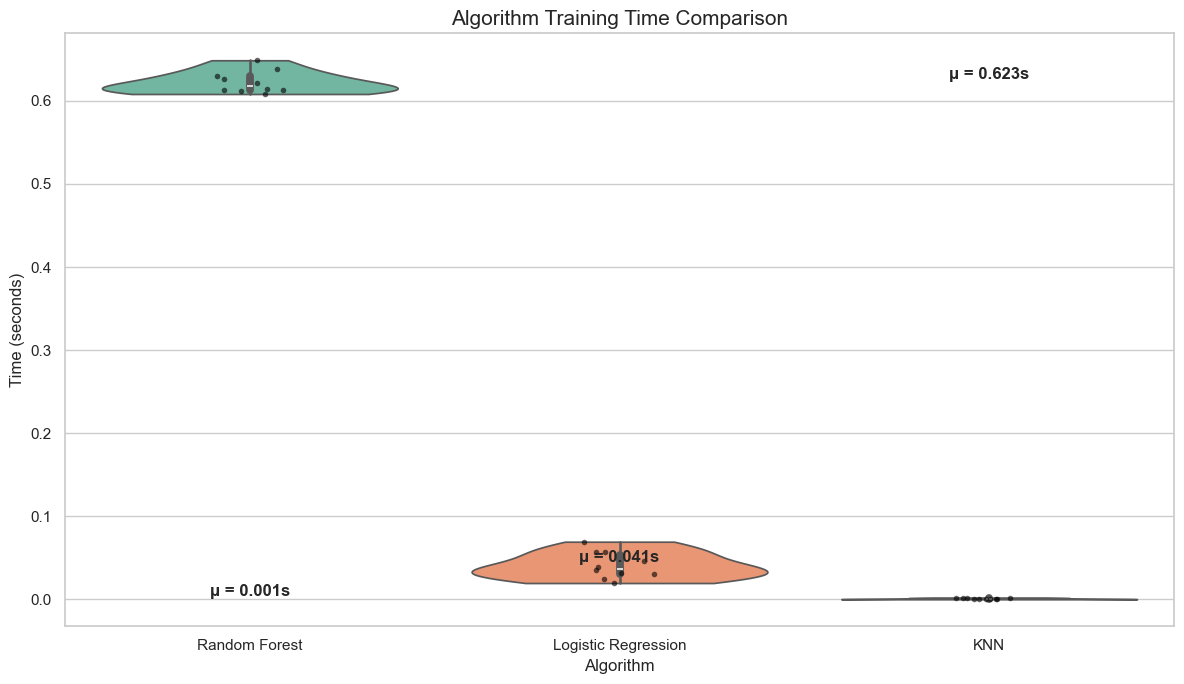

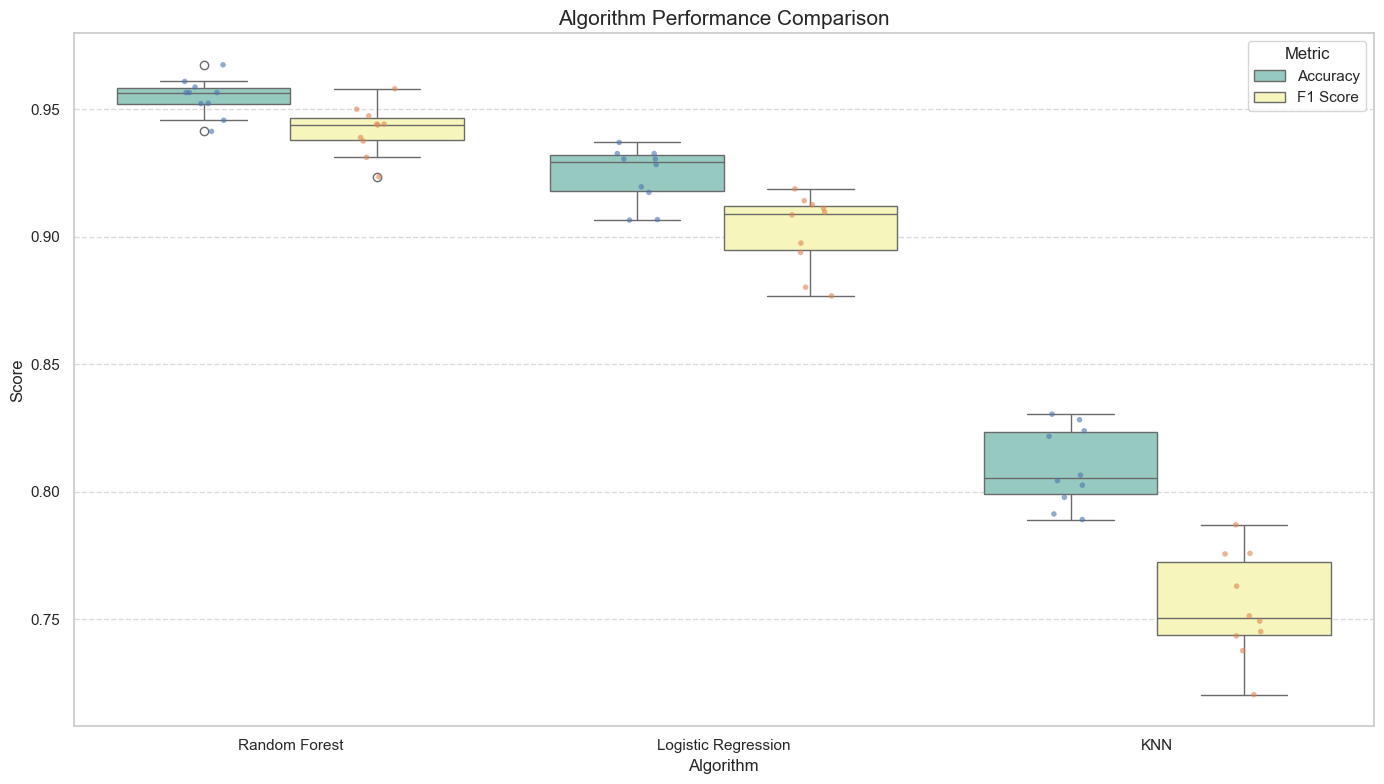

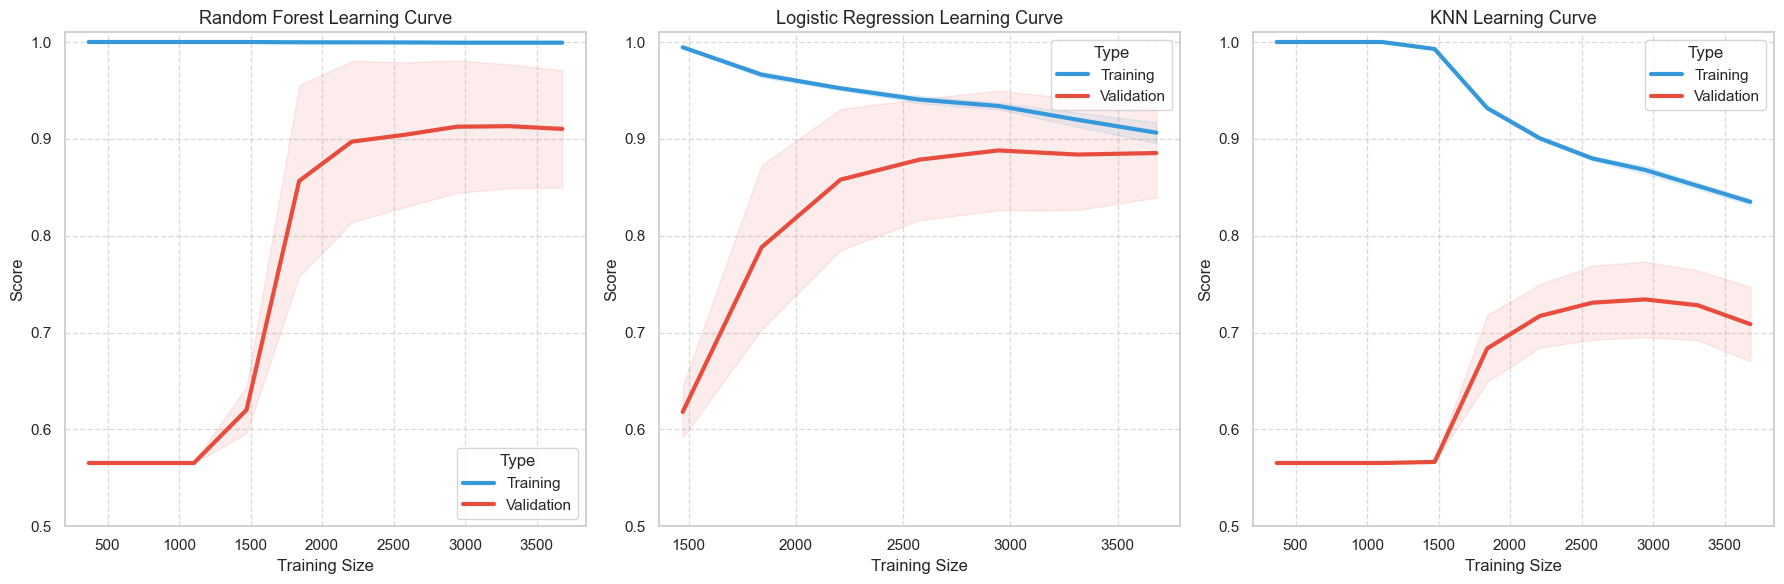

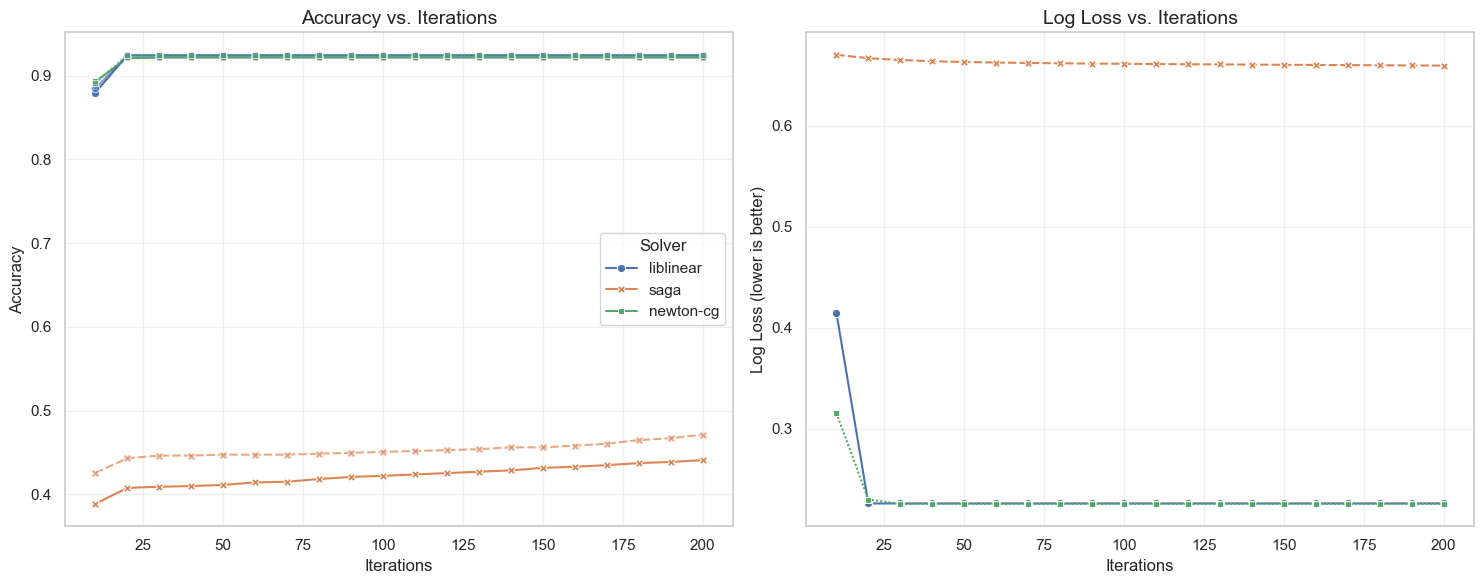

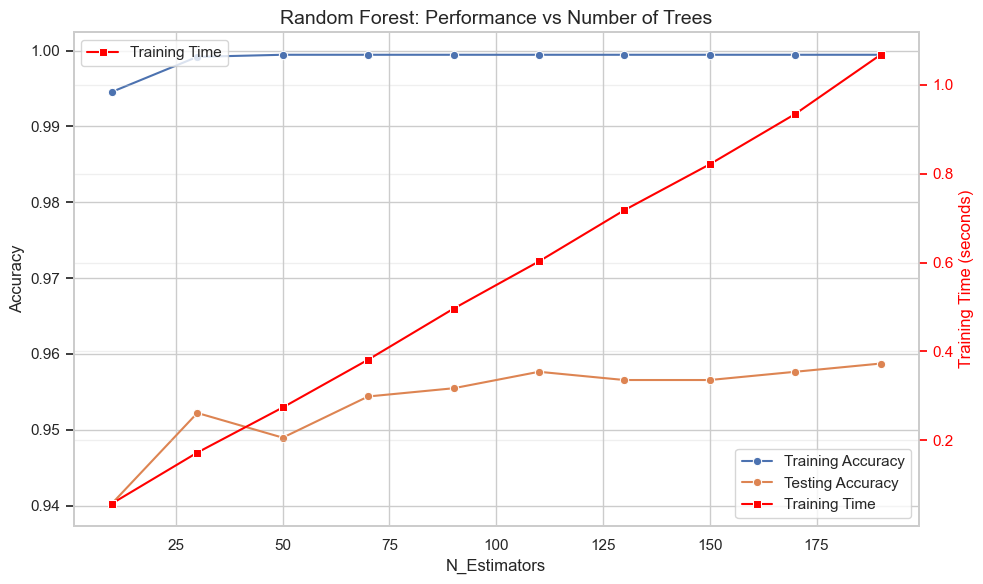

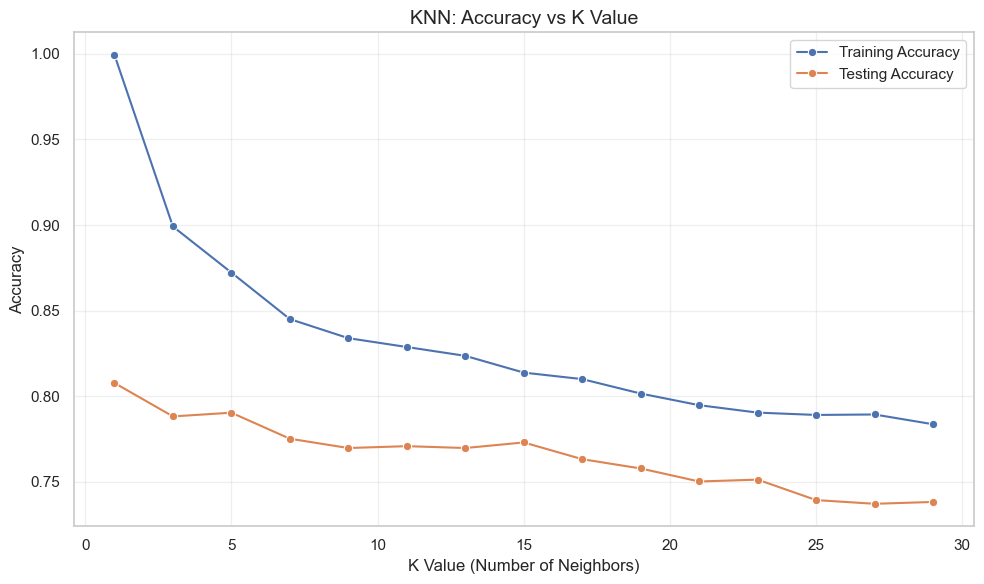

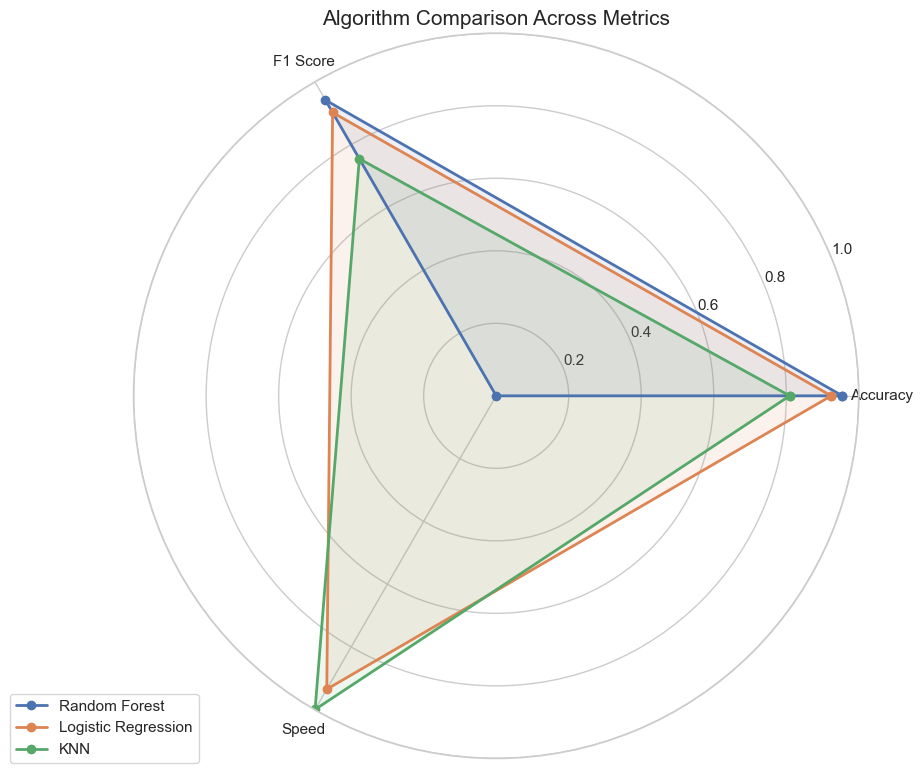

In [66]:
# Main Function
def main():
    # Load data
    X, y = load_data()
    
    # Initialize classifiers
    classifiers = initialize_classifiers()
    
    # Metrics to evaluate
    metrics = ['accuracy', 'f1', 'time']
    
    # Dictionary to store all results for later analysis
    all_results = {}
    
    # Perform evaluation for each metric
    for metric in metrics:
        print(f"\n{'=' * 80}")
        print(f"Evaluating {metric.upper()}:")
        print(f"{'=' * 80}")
        
        # Store results for each classifier
        results = {}
        for name, clf in classifiers:
            print(f"Running {name}...")
            scores = perform_cross_validation(X, y, clf, metric)
            results[name] = scores
        
        all_results[metric] = results
        
        # Print the results table
        print(f"\nResults for {metric}:")
        print_results_table(results, metric)
        
        # Perform Friedman test
        statistic, p_value, rank_dict = friedman_test(results)
        
        print(f"\nFriedman test for {metric}:")
        print_friedman_table(results, statistic, p_value, rank_dict)
        
        # If the null hypothesis is rejected, perform Nemenyi test
        if p_value < 0.05:
            critical_difference, average_ranks = nemenyi_test(results)
            print(f"\nNemenyi test for {metric}:")
            print(f"Critical difference: {critical_difference:.4f}")
            
            # Print pairwise comparisons
            print("\nPairwise comparisons:")
            sorted_ranks = sorted(average_ranks.items(), key=lambda x: x[1])
            for i in range(len(sorted_ranks)):
                for j in range(i+1, len(sorted_ranks)):
                    clf1, rank1 = sorted_ranks[i]
                    clf2, rank2 = sorted_ranks[j]
                    diff = abs(rank1 - rank2)
                    significant = diff > critical_difference
                    print(f"{clf1} vs {clf2}: Rank difference = {diff:.4f} {'(Significant)' if significant else '(Not significant)'}")
            
            # Plot critical difference diagram
            plot_critical_difference_diagram(average_ranks, critical_difference, metric)
    
    # Create a summary table
    summary_data = []
    headers = ["Algorithm", "Accuracy (Mean±Std)", "F1 Score (Mean±Std)", "Training Time (Mean±Std)"]
    
    for name, _ in classifiers:
        acc_scores = all_results['accuracy'][name]
        f1_scores = all_results['f1'][name]
        time_scores = all_results['time'][name]
        
        acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
        time_mean, time_std = np.mean(time_scores), np.std(time_scores)
        
        summary_data.append([
            name,
            f"{acc_mean:.4f}±{acc_std:.4f}",
            f"{f1_mean:.4f}±{f1_std:.4f}",
            f"{time_mean:.3f}±{time_std:.3f}"
        ])
    
    print("\n\nSummary of Results:")
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Create a plot to visualize the performance across metrics
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Accuracy
    plt.subplot(1, 3, 1)
    for name, _ in classifiers:
        plt.plot(range(1, 11), all_results['accuracy'][name], marker='o', label=name)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy across Folds')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: F1 Score
    plt.subplot(1, 3, 2)
    for name, _ in classifiers:
        plt.plot(range(1, 11), all_results['f1'][name], marker='o', label=name)
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score across Folds')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: Training Time
    plt.subplot(1, 3, 3)
    for name, _ in classifiers:
        plt.plot(range(1, 11), all_results['time'][name], marker='o', label=name)
    plt.xlabel('Fold')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time across Folds')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("performance_comparison.png")
    plt.close()

    # Add the call to create Seaborn visualizations
    create_visualizations(X, y, classifiers, all_results)


if __name__ == "__main__":
    main()